<a href="https://colab.research.google.com/github/border-b/QMLHEP/blob/main/QMLHEP_Test_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Task IV: Quantum Generative Adversarial Network (QGAN)**

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. 

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [[Download Input]](https://drive.google.com/file/d/1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj/view). In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this task. The signal events are labeled with 1 while the background events are labeled with 0.

Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 


In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum
!pip install cirq

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/GSoC2023'

/content/drive/MyDrive/GSoC2023


In [ ]:
data = np.load('QIS_EXAM_200Events.npz', allow_pickle=True)
print(data.files)

['training_input', 'test_input']


In [ ]:
X_train=data['training_input'].item()
X_test=data['test_input'].item()

X_train_0 = X_train['0']
X_train_1 = X_train['1']
X_test_0 = X_test['0']
X_test_1 = X_test['1']

X_train = np.concatenate((X_train_0,X_train_1),axis=0)
X_test = np.concatenate((X_test_0,X_test_1),axis=0)

y_train = np.zeros((len(X_train),1))
y_train[len(X_train_0):] = 1
y_test = np.zeros((len(X_test),))
y_test[len(X_test_0):] = 1

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)*2 - 1
y_test = tf.keras.utils.to_categorical(y_test)*2 -1

y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

### Data Encoding

In [ ]:
def generate_quantum_data(X,qubits):
    quantum_data =[]
    for i in X:
        circuit = cirq.Circuit()
        
        for j in range(len(i)):
            circuit.append(cirq.ry(i[j])(qubits[j]))
            
        quantum_data.append(circuit)
    return quantum_data

In [ ]:
qubits = cirq.GridQubit.rect(1, 5)
train_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_test, qubits))

In [ ]:

# label 1
# print(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==1][0])
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit
     

In [ ]:
def generator(qubits,symbols,layers=1):
  circuit = cirq.Circuit()
  data_qubits_size =int(len(qubits)/2)
  rand_rot = np.random.normal(loc=0,scale=np.pi/4,size=data_qubits_size)
  for i in range(data_qubits_size):
    circuit.append(cirq.ry(rand_rot[i])(qubits[i]))

  for layer in range(layers):
    for i in range(len(qubits)):
      circuit += one_qubit_unitary(qubits[i],symbols[3*i+3*layer*len(qubits):3*(i+1)+3*layer*len(qubits)])
  
    for i in range(len(qubits)):
      if(i<len(qubits)-1):
        circuit.append(cirq.CNOT(qubits[i],qubits[i+1]))
  
  last_unitary_symbols=symbols[-(3*data_qubits_size):]
  for i in range(data_qubits_size):
    circuit += one_qubit_unitary(qubits[i],last_unitary_symbols[3*i:3*(i+1)])
  return circuit

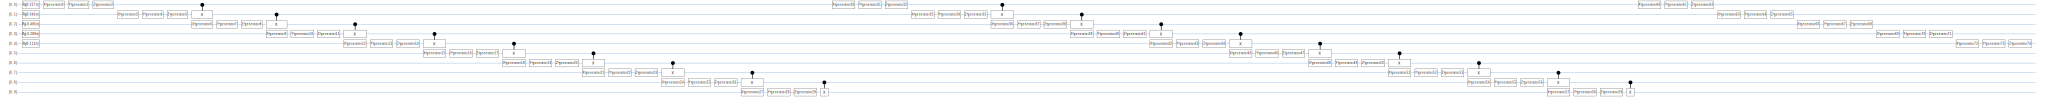

In [ ]:
import sympy
# params total: (3*features*2)*layer params + (3*features) final params
SVGCircuit(generator(cirq.GridQubit.rect(1,10),sympy.symbols('generator:75'),layers=2))

In [ ]:
def discriminator(data_qubits, output_qubits, symbols, layers =1):
  circuit = cirq.Circuit()
  for i in range(len(data_qubits)):
    circuit.append(cirq.H(data_qubits[i]))
  qubits = data_qubits+output_qubits
  for layer in range(layers):
    for i in range(len(data_qubits+output_qubits)):
      circuit += one_qubit_unitary(qubits[i],symbols[3*i + 3*layer*len(qubits) : 3*(i+1) + 3*layer*len(qubits)])
  
    for i in range(len(data_qubits+output_qubits)):
       if(i<len(data_qubits+output_qubits)-1):
         circuit.append(cirq.CNOT(qubits[i],qubits[i+1]))
  
  output_qubit_symbols = symbols[-3*(len(output_qubits)):]
  for i in range(len(output_qubits)):
    circuit += one_qubit_unitary(output_qubits[i],output_qubit_symbols[3*i:3*(i+1)])
  return circuit

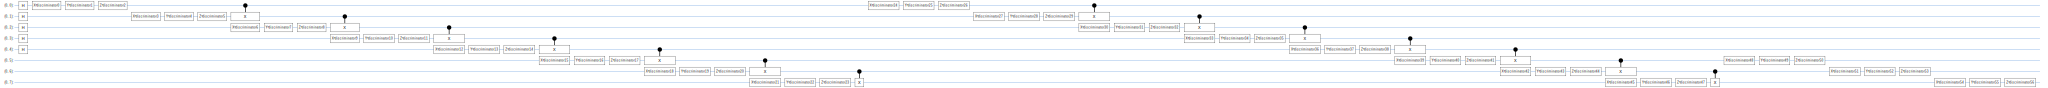

In [ ]:
disc_qubits = cirq.GridQubit.rect(1,5+3)
SVGCircuit(discriminator(disc_qubits[:5],disc_qubits[5:],sympy.symbols('discriminator:57'),layers=2))

In [ ]:
def generator_discriminator(gen_qubits, disc_qubits,gen_symbols,disc_symbols,gen_layers=1,disc_layers=1):
  gen_disc_circuit = cirq.Circuit()
  
  gen_disc_circuit += generator(gen_qubits,gen_symbols)

  gen_disc_circuit += discriminator(disc_qubits[:5],disc_qubits[5:],disc_symbols) 

  return gen_disc_circuit

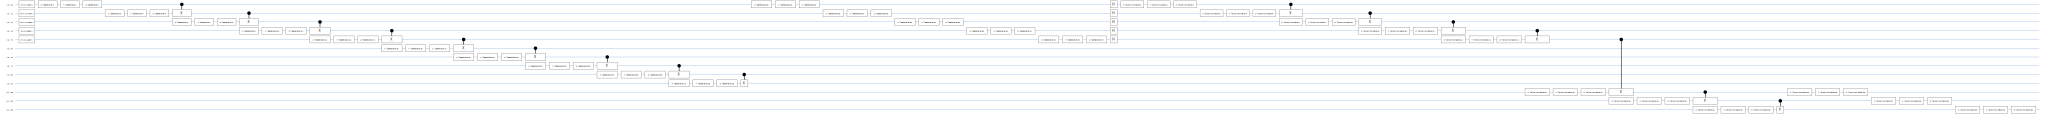

In [ ]:
gen_disc_qubits = cirq.GridQubit.rect(1,13)
gen_symbols = sympy.symbols('generator:45')
disc_symbols = sympy.symbols('discriminator:33')
SVGCircuit(generator_discriminator(gen_disc_qubits[:10],gen_disc_qubits[:5]+gen_disc_qubits[10:],gen_symbols,disc_symbols))

In [ ]:
num_classes = 2
features = 5
gen_layers = 4
disc_layers = 4

In [ ]:
gen_total_params = (3*features*2)*gen_layers + 3*features
disc_total_params = 3*(features+num_classes+1)*disc_layers + 3*(num_classes+1)

train_gen_symbols = sympy.symbols('generator:'+str(gen_total_params))
train_disc_symbols = sympy.symbols('discriminator:'+str(disc_total_params))

model_qubits = cirq.GridQubit.rect(1,features*2+num_classes+1)

### Discriminator

In [ ]:
C = 1/2
@tf.function
def disc_loss(y_true,y_pred):
  D_true = (y_true[:,2]+1)/2
  D_pred = (y_pred[:,2]+1)/2
  # D_true_size = tf.cast(tf.size(tf.where(D_true==1 ),out_type= tf.int32)) + 1e-15
 
  # Loss in predicting true or fake
  L_tf = -(tf.math.log(D_pred + 1e-15)*D_true + tf.math.log(1- D_pred +1e-15)*(1-D_true))
  L_tf = tf.reduce_mean(L_tf, axis=0)
  C_true = (y_true[:,:2]+1)/2
  C_pred = (y_pred[:,:2]+1)/2
  # Loss in classification
  D_true_size = tf.cast(tf.size(tf.where(D_true==1 ),out_type= tf.int32), dtype=tf.float32) + 1e-15
  L_c = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true,C_pred)*D_true)/D_true_size

  # Total Loss of discrminator
  Loss = ((L_tf)*(1-C) + C*L_c)
  return Loss

In [ ]:
@tf.function
def custom_accuracy(y_true,y_pred):
  D_true = (y_true[:,2]+1)/2

  C_real_true = (y_true[:,:2]+1)/2
  C_real_pred = (y_pred[:,:2]+1)/2
  
  C_real_true = tf.math.argmax(C_real_true,axis=1)
  C_real_pred = tf.math.argmax(C_real_pred,axis=1)
  D_true_size = tf.cast(tf.size(tf.where(D_true==1 ),out_type= tf.int32), dtype=tf.float32) + 1e-15

  same = tf.cast(C_real_true == C_real_pred, tf.float32)*D_true
  return tf.math.reduce_sum(same)/D_true_size

### Generator

In [ ]:
@tf.function
def gen_loss(y_true,y_pred):
  y_pred = (y_pred+1)/2
  return tf.reduce_mean((-1)*tf.math.log(y_pred),axis=0)

### Discriminator Model

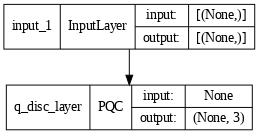

In [ ]:
def discriminator_model(disc_weights):
  disc_readout_ops = [cirq.Z(model_qubits[-1*(num_classes+1)+i]) for i in range(num_classes+1)]

  data_input = tf.keras.Input(shape = (), dtype = tf.dtypes.string)
  qdisc_layer = tfq.layers.PQC(discriminator(model_qubits[:int((len(model_qubits)-(num_classes+1))/2)],
                                  model_qubits[(len(model_qubits)-(num_classes+1)):], disc_weights,disc_layers),
                    disc_readout_ops,
                    name = 'q_disc_layer'
                    )(data_input)
  qdisc_model = tf.keras.Model(inputs = [data_input], outputs = [qdisc_layer])
  qdisc_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                      loss = [disc_loss],
                      metrics = [custom_accuracy]
                      )
  return qdisc_model

qdisc_model = discriminator_model(train_disc_symbols)
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

### Generator Model

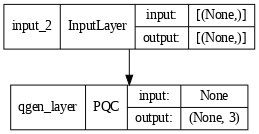

In [ ]:
def generator_model(qgen_weights,qdisc_weights):
  qgen_readout_operators = [cirq.Z(model_qubits[-1*(num_classes+1)+i]) for i in range(num_classes+1)]

  data_input = tf.keras.Input(shape = (), dtype = tf.dtypes.string)
  qgen_layer = tfq.layers.PQC(generator_discriminator(model_qubits[:features*2],model_qubits[:features]+model_qubits[len(model_qubits)-(num_classes+1):],
                              qgen_weights,qdisc_weights,
                              gen_layers,disc_layers),
                              qgen_readout_operators,name = 'qgen_layer')(data_input)

  qgen_model = tf.keras.Model(inputs=[data_input],outputs=[qgen_layer])
  qgen_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss = [gen_loss])
  return qgen_model

qgen_model = generator_model(train_gen_symbols,qdisc_model.get_weights()[0])

tf.keras.utils.plot_model(qgen_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [ ]:
# Generatting identity data for generator training in first cycle
def generate_identity_data(X):
  quantum_data=[]
  for i in X:
    circuit = cirq.Circuit()
    quantum_data.append(circuit)
  return quantum_data

In [ ]:
identity_data = tfq.convert_to_tensor(generate_identity_data(X_train))
identity_label = np.zeros((len(identity_data)),)

print(len(identity_data))
print(identity_label.shape)
print(type(generate_identity_data(X_train)[10]))

100
(100,)
<class 'cirq.circuits.circuit.Circuit'>


In [ ]:
def generate_fake_data(X,qubits,symbols,layer=1):
  quantum_data=[]
  for i in X:
    quantum_data.append(generator(qubits[:2*len(i)],symbols,layer))
  
  return quantum_data

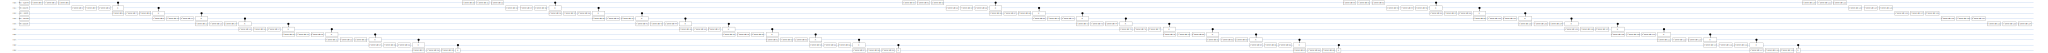

In [ ]:
fake_quantum_data = generate_fake_data(X_train,model_qubits,train_gen_symbols,gen_layers)
y_true_fake = np.zeros((len(fake_quantum_data), num_classes+1))
y_true_fake[:, 2] += (-1)
SVGCircuit(fake_quantum_data[0])

### Training Model

In [ ]:
qdisc_model = discriminator_model(train_disc_symbols)
qgen_model = generator_model(train_gen_symbols,qdisc_model.get_weights()[0]) 

In [ ]:
def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='QMLHEP_test4_checkpoints_gen_c' + str(cycle)+ '.csv',
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
    
    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='QMLHEP_test4_checkpoints_disc_c' + str(cycle) +'.csv',
        save_weights_only=True,
        monitor='custom_accuracy',
        mode='max',
        save_best_only=True)
    
    return gen_model_cp, disc_model_cp

In [ ]:
def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    qgen_history = qgen_model.fit(x=identity_data,
                            y=identity_label,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[gen_model_cp])
    return qgen_history

In [ ]:
def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(x=train_gen_data,
                            y=y_gen_train,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[disc_model_cp],
                            validation_data=(test_gen_data, y_gen_test)
                            )
    return history

### First Cycle

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

#re-declare the generator model using the discriminator's weights
qgen_model = generator_model(train_gen_symbols, qdisc_model.get_weights()[0])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=1)

In [ ]:
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.8995
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8987
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8978
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8970
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8961
Epoch 6/1000
1/1 [==============================] - 1s 803ms/step - loss: 0.8953
Epoch 7/1000
1/1 [==============================] - 1s 802ms/step - loss: 0.8944
Epoch 8/1000
1/1 [==============================] - 1s 805ms/step - loss: 0.8936
Epoch 9/1000
1/1 [==============================] - 1s 778ms/step - loss: 0.8927
Epoch 10/1000
1/1 [==============================] - 1s 802ms/step - loss: 0.8919
Epoch 11/1000
1/1 [==============================] - 1s 846ms/step - loss: 0.8911
Epoch 12/1000
1/1 [==============================] - 1s 811ms/step - loss: 0.8902
Epoch 13/1000
1/1 [=====================

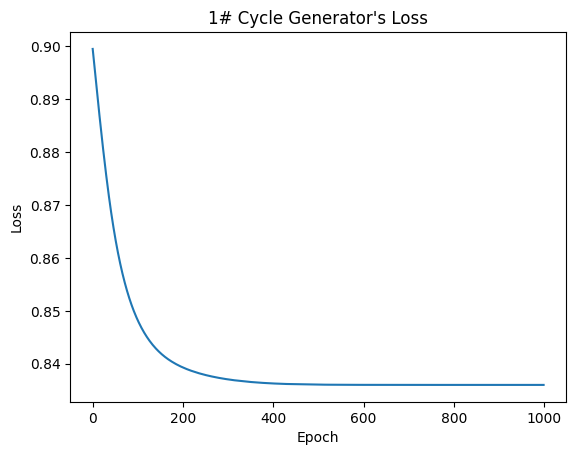

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generating data for discriminator by mixing real and fake data
# C = 1/2 (default value)
train_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_train,model_qubits) + generate_fake_data(X_train,model_qubits,qgen_model.get_weights()[0]),gen_layers)
test_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_test,model_qubits) + generate_fake_data(X_test,model_qubits,qgen_model.get_weights()[0]),gen_layers)

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)
                            
print(len(train_gen_data), len(test_gen_data))
print(y_gen_train.shape, y_gen_test.shape)                            

200 200
(200, 3) (200, 3)


In [ ]:
# Fit the Discriminator Model
H = train_qdisc(200, 75, 1)

Epoch 1/200
3/3 [==============================] - 8s 3s/step - loss: 0.7017 - custom_accuracy: 0.5908 - val_loss: 0.5978 - val_custom_accuracy: 0.3733
Epoch 2/200
3/3 [==============================] - 6s 2s/step - loss: 0.6951 - custom_accuracy: 0.6244 - val_loss: 0.5956 - val_custom_accuracy: 0.3689
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 0.6924 - custom_accuracy: 0.6131 - val_loss: 0.5936 - val_custom_accuracy: 0.3689
Epoch 4/200
3/3 [==============================] - 3s 1s/step - loss: 0.6852 - custom_accuracy: 0.5807 - val_loss: 0.5914 - val_custom_accuracy: 0.3689
Epoch 5/200
3/3 [==============================] - 4s 1s/step - loss: 0.6826 - custom_accuracy: 0.5747 - val_loss: 0.5894 - val_custom_accuracy: 0.3867
Epoch 6/200
3/3 [==============================] - 6s 2s/step - loss: 0.6771 - custom_accuracy: 0.6333 - val_loss: 0.5874 - val_custom_accuracy: 0.4044
Epoch 7/200
3/3 [==============================] - 5s 2s/step - loss: 0.6717 - custom_ac

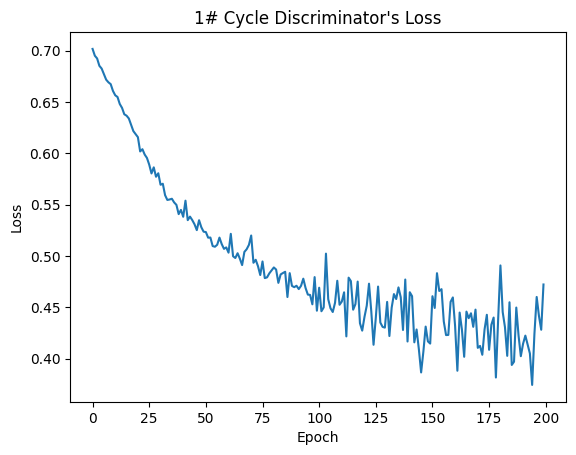

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Discriminator's Loss")
plt.show() 

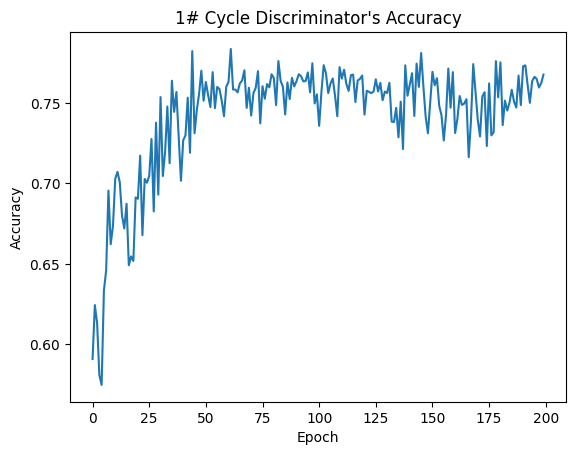

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("1# Cycle Discriminator's Accuracy")
plt.show() 

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(test_gen_data))


<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

### Second Cycle

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(train_gen_symbols, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('q_disc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

In [ ]:
H = train_qgen(800, 100, 1)

Epoch 1/800
1/1 [==============================] - 2s 2s/step - loss: 0.7739
Epoch 2/800
1/1 [==============================] - 1s 800ms/step - loss: 0.7734
Epoch 3/800
1/1 [==============================] - 1s 806ms/step - loss: 0.7729
Epoch 4/800
1/1 [==============================] - 1s 823ms/step - loss: 0.7724
Epoch 5/800
1/1 [==============================] - 1s 782ms/step - loss: 0.7719
Epoch 6/800
1/1 [==============================] - 1s 834ms/step - loss: 0.7714
Epoch 7/800
1/1 [==============================] - 1s 802ms/step - loss: 0.7710
Epoch 8/800
1/1 [==============================] - 1s 818ms/step - loss: 0.7705
Epoch 9/800
1/1 [==============================] - 1s 823ms/step - loss: 0.7700
Epoch 10/800
1/1 [==============================] - 1s 766ms/step - loss: 0.7695
Epoch 11/800
1/1 [==============================] - 1s 916ms/step - loss: 0.7690
Epoch 12/800
1/1 [==============================] - 1s 1s/step - loss: 0.7686
Epoch 13/800
1/1 [=========================

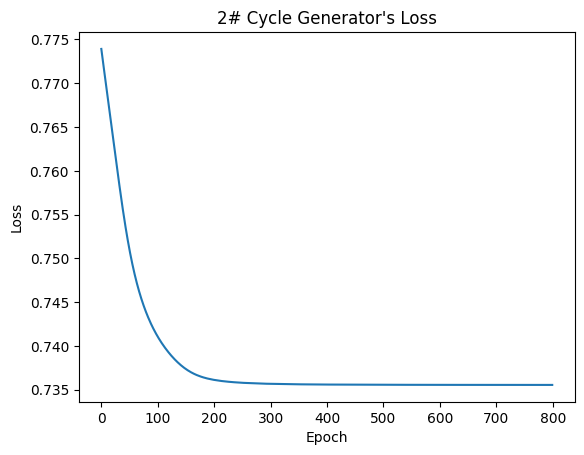

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generating data for discriminator by mixing real and fake data
# Increasing value of C to make the discriminator biased towards classification part 
C = 0.8
train_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_train,model_qubits) + generate_fake_data(X_train,model_qubits,qgen_model.get_weights()[0]),gen_layers)
test_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_test,model_qubits) + generate_fake_data(X_test,model_qubits,qgen_model.get_weights()[0]),gen_layers)

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)
                            
print(len(train_gen_data), len(test_gen_data))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
H = train_qdisc(400, 90, 1)

Epoch 1/400
3/3 [==============================] - 5s 2s/step - loss: 0.4044 - custom_accuracy: 0.7749 - val_loss: 0.7361 - val_custom_accuracy: 0.4704
Epoch 2/400
3/3 [==============================] - 6s 2s/step - loss: 0.4123 - custom_accuracy: 0.7709 - val_loss: 0.7312 - val_custom_accuracy: 0.4704
Epoch 3/400
3/3 [==============================] - 4s 1s/step - loss: 0.4287 - custom_accuracy: 0.7945 - val_loss: 0.7274 - val_custom_accuracy: 0.4704
Epoch 4/400
3/3 [==============================] - 4s 1s/step - loss: 0.4194 - custom_accuracy: 0.7800 - val_loss: 0.7210 - val_custom_accuracy: 0.4704
Epoch 5/400
3/3 [==============================] - 4s 1s/step - loss: 0.4144 - custom_accuracy: 0.7219 - val_loss: 0.7104 - val_custom_accuracy: 0.4704
Epoch 6/400
3/3 [==============================] - 6s 2s/step - loss: 0.4068 - custom_accuracy: 0.7963 - val_loss: 0.7012 - val_custom_accuracy: 0.4704
Epoch 7/400
3/3 [==============================] - 6s 2s/step - loss: 0.3794 - custom_ac

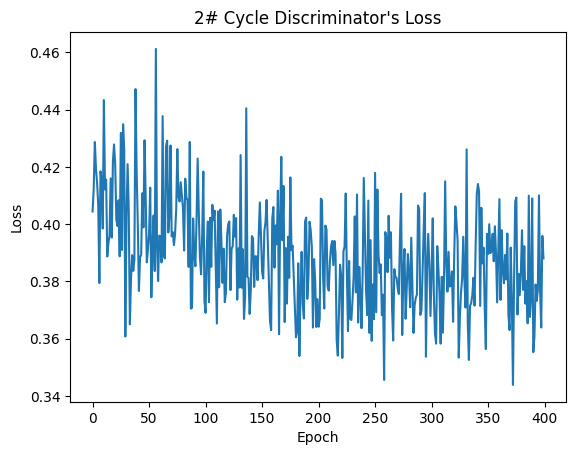

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Discriminator's Loss")
plt.show() 

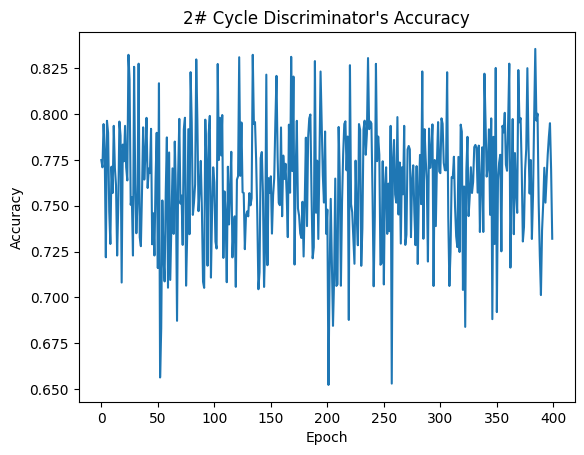

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("2# Cycle Discriminator's Accuracy")
plt.show() 

### Third Cycle

In [ ]:

best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(train_gen_symbols, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('q_disc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=3)

In [ ]:
H = train_qgen(500, 80, 1)

Epoch 1/500
2/2 [==============================] - 2s 669ms/step - loss: 0.7404
Epoch 2/500
2/2 [==============================] - 1s 385ms/step - loss: 0.7394
Epoch 3/500
2/2 [==============================] - 1s 347ms/step - loss: 0.7384
Epoch 4/500
2/2 [==============================] - 1s 362ms/step - loss: 0.7375
Epoch 5/500
2/2 [==============================] - 1s 207ms/step - loss: 0.7366
Epoch 6/500
2/2 [==============================] - 1s 203ms/step - loss: 0.7356
Epoch 7/500
2/2 [==============================] - 1s 226ms/step - loss: 0.7347
Epoch 8/500
2/2 [==============================] - 1s 240ms/step - loss: 0.7338
Epoch 9/500
2/2 [==============================] - 1s 221ms/step - loss: 0.7329
Epoch 10/500
2/2 [==============================] - 1s 226ms/step - loss: 0.7319
Epoch 11/500
2/2 [==============================] - 1s 208ms/step - loss: 0.7310
Epoch 12/500
2/2 [==============================] - 1s 237ms/step - loss: 0.7300
Epoch 13/500
2/2 [===================

In [ ]:
# Generating data for discriminator by mixing real and fake data
C = 0.9
train_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_train,model_qubits) + generate_fake_data(X_train,model_qubits,qgen_model.get_weights()[0]),gen_layers)
test_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_test,model_qubits) + generate_fake_data(X_test,model_qubits,qgen_model.get_weights()[0]),gen_layers)

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)
                            
print(len(train_gen_data), len(test_gen_data))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
H = train_qdisc(600, 100, 1)

Epoch 1/600
2/2 [==============================] - 5s 3s/step - loss: 0.5053 - custom_accuracy: 0.7628 - val_loss: 0.3323 - val_custom_accuracy: 0.3550
Epoch 2/600
2/2 [==============================] - 5s 3s/step - loss: 0.5023 - custom_accuracy: 0.7591 - val_loss: 0.3323 - val_custom_accuracy: 0.3550
Epoch 3/600
2/2 [==============================] - 6s 4s/step - loss: 0.5063 - custom_accuracy: 0.7615 - val_loss: 0.3324 - val_custom_accuracy: 0.3550
Epoch 4/600
2/2 [==============================] - 4s 2s/step - loss: 0.5011 - custom_accuracy: 0.7607 - val_loss: 0.3324 - val_custom_accuracy: 0.3550
Epoch 5/600
2/2 [==============================] - 4s 2s/step - loss: 0.5121 - custom_accuracy: 0.7555 - val_loss: 0.3324 - val_custom_accuracy: 0.3550
Epoch 6/600
2/2 [==============================] - 4s 2s/step - loss: 0.5036 - custom_accuracy: 0.7600 - val_loss: 0.3324 - val_custom_accuracy: 0.3550
Epoch 7/600
2/2 [==============================] - 6s 4s/step - loss: 0.5049 - custom_ac

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3# Cycle Discriminator's Loss")
plt.show() 

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("3# Cycle Discriminator's Accuracy")
plt.show() 

### Checking on Training Data

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(train_gen_symbols, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('q_disc_layer').set_weights([best_qdisc_weights])

In [ ]:
C=1
gen_model_cp, disc_model_cp = checkpoints(cycle=5)


In [ ]:
history = qdisc_model.fit(x=train_quantum_data,
                            y=y_train,
                            batch_size=30,
                            epochs=50,
                            verbose=1,
                            callbacks=[disc_model_cp],
                            validation_data=(test_quantum_data, y_test)
                            )

In [ ]:
# Fit the Discriminator Model
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=30,
                          epochs=100,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("5# Cycle Discriminator's Loss")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))